## E-commerce Business Transaction Analytics
_source : https://www.kaggle.com/datasets/gabrielramos87/an-online-shop-business_

***

#### About the data:
This is a sales transaction data set of UK-based e-commerce (online retail) for one year. This London-based shop has been selling gifts and homewares for adults and children through the website since 2007. Their customers come from all over the world and usually make direct purchases for themselves. There are also small businesses that buy in bulk and sell to other customers through retail outlet channels.

The data set contains __500K rows__ and __8 columns__. The following is the description of each column.

 1) __TransactionNo__ (categorical): a six-digit unique number that defines each transaction. (_The letter “C” in the code indicates a cancellation_).

 2) __Date__ (numeric): the date when each transaction was generated.

 3) __ProductNo__ (categorical): a five or six-digit unique character used to identify a specific product.

 4) __Product__ (categorical): product/item name.

 5) __Price__ (numeric): the price of each product per unit in pound sterling (£).

 6) __Quantity__ (numeric): the quantity of each product per transaction. (_Negative values indicate cancelled transactions_).

 7) __CustomerNo__ (categorical): a five-digit unique number that defines each customer.

 8) __Country__ (categorical): name of the country where the customer resides.

There is a small percentage of __order cancellation__ in the data set. Most of these cancellations were due to out-of-stock conditions on some products. Under this situation, customers tend to cancel an order as they want all products delivered all at once.

----------

#### Overview - Expected research outcomes

Transaction data analysis is a process of examining and interpreting data collected from customer transactions in order to gain insights and make informed business decisions. For an e-commerce business, analyzing transaction data over the course of a year can help in several departments.

Given the scope of the data features provided in this dataset, we will focus our attention in the following:

-  Identifying sales patterns / distribution of transactions and revenue over time,

-  Understanding the demographics and purchasing habits of the customers,

-  Insights concering product popularity/profitability,

-  Customer retention.


Overall, analyzing transaction data can provide valuable insights that can help an e-commerce business make data-driven decisions to improve its performance.

---------

####  Table of Contents

1) [Importing, cleaning and validating the data](#importing-cleaning-and-validating-the-data)

2) [Exploratory analysis - Understanding the data](#exploratory-analysis---understanding-the-data)

3) [Market Basket Analysis](#market-basket-analysis)

4) [Cohort Analysis](#customer-retention-through-cohort-analysis)

-------

### Importing, cleaning and validating the data <a class="anchor" id="importing-cleaning-and-validating-the-data"></a>

#### Dependencies

In [95]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from mlxtend.frequent_patterns import apriori, association_rules 
from sklearn.linear_model import LinearRegression
from operator import attrgetter

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

#### Importing dataset into a pandas dataframe

In [96]:
df = pd.read_csv("Sales_Data.csv")

#### Dataframe overview

In [97]:
def data_report(dataframe):
    """ Function to get a dataframe review """
    print(dataframe.info())
    print("\n")
    print(dataframe.describe())
    print("\n")
    print(df.isnull().sum())

data_report(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536350 entries, 0 to 536349
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionNo  536350 non-null  object 
 1   Date           536350 non-null  object 
 2   ProductNo      536350 non-null  object 
 3   ProductName    536350 non-null  object 
 4   Price          536350 non-null  float64
 5   Quantity       536350 non-null  int64  
 6   CustomerNo     536295 non-null  float64
 7   Country        536350 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 32.7+ MB
None


               Price       Quantity     CustomerNo
count  536350.000000  536350.000000  536295.000000
mean       12.662182       9.919347   15227.893178
std         8.490450     216.662300    1716.582932
min         5.130000  -80995.000000   12004.000000
25%        10.990000       1.000000   13807.000000
50%        11.940000       3.000000   15152.000000
75%        14

#### Dropping duplicate rows

In [98]:
df.drop_duplicates(inplace=True)

#### Dropping rows with null values for the Customer_id feature

In [99]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

#### Renaming the columns in the dataframe

In [100]:
df.rename(columns={
"TransactionNo":"Transaction_id",
"ProductName":"Product_name",
"ProductNo":"Product_id",
"CustomerNo":"Customer_id"}, inplace=True)

#### Casting data in the Date column into datetime type

In [101]:
df["Date"] = pd.to_datetime(df["Date"])

### Exploratory analysis - Understanding the data <a class="anchor" id="exploratory-analysis---understanding-the-data"></a>

#### Finding the time range of the transactions recorded into the dataset

In [102]:
max_date = df["Date"].max()
min_date = df["Date"].min()
print(f'Earliest data log at: {min_date}')
print(f'Latest data log at: {max_date}')
print(f'Dataframe total time duration: {max_date - min_date}')

Earliest data log at: 2018-12-01 00:00:00
Latest data log at: 2019-12-09 00:00:00
Dataframe total time duration: 373 days 00:00:00


#### Adding the following features as columns in the dataframe:

 - Day

 - Month

 - Year

 - Day_name
 
 - Transaction_profit

In [103]:
df["Day"] = df["Date"].dt.day
df["Month"] = df["Date"].dt.month
df["Year"] = df["Date"].dt.year
df["Day_name"] = df["Date"].dt.day_name()
df["Transaction_profit"] = df["Price"] * df["Quantity"]
df.head()

,Transaction_id,Date,Product_id,Product_name,Price,Quantity,Customer_id,Country,Day,Month,Year,Day_name,Transaction_profit
0,581482,2019-12-09,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom,9,12,2019,Monday,257.64
1,581475,2019-12-09,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom,9,12,2019,Monday,383.40
2,581475,2019-12-09,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom,9,12,2019,Monday,138.36
3,581475,2019-12-09,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069.0,United Kingdom,9,12,2019,Monday,127.80
4,581475,2019-12-09,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069.0,United Kingdom,9,12,2019,Monday,71.64


#### Filtering out the data from December 2018, we will focus only on 2019 data forward

In [104]:
df = df[df["Year"] == 2019]

#### Validating which rows contain cancelled transactions

In [105]:
# Counting how many invalid transaction / cancelled are there through the Transaction_id values
number_tid_cancelled = df[df["Transaction_id"].str.contains("C", regex=True)].shape[0]

# Counting how many invalid transaction / cancelled are there through the Quantity values
number_q_cancelled = df[df["Quantity"]<0].shape[0]

if number_tid_cancelled == number_q_cancelled:
    print(f"There are {number_q_cancelled} rows of cancelled transactions in the dataframe.")
    print(f'These rows correspond to {df["Transaction_id"][df["Quantity"]<0].nunique()} unique transactions that got cancelled.')
else:
    print("Invalid data.")

There are 7831 rows of cancelled transactions in the dataframe.
These rows correspond to 3082 unique transactions that got cancelled.


#### Create a new dataframe containing only cancelled transactions out of the original dataframe

In [106]:
cancelled = df[df["Quantity"]<0].copy()

#### Distribution of transactions and cancellations per month of 2019

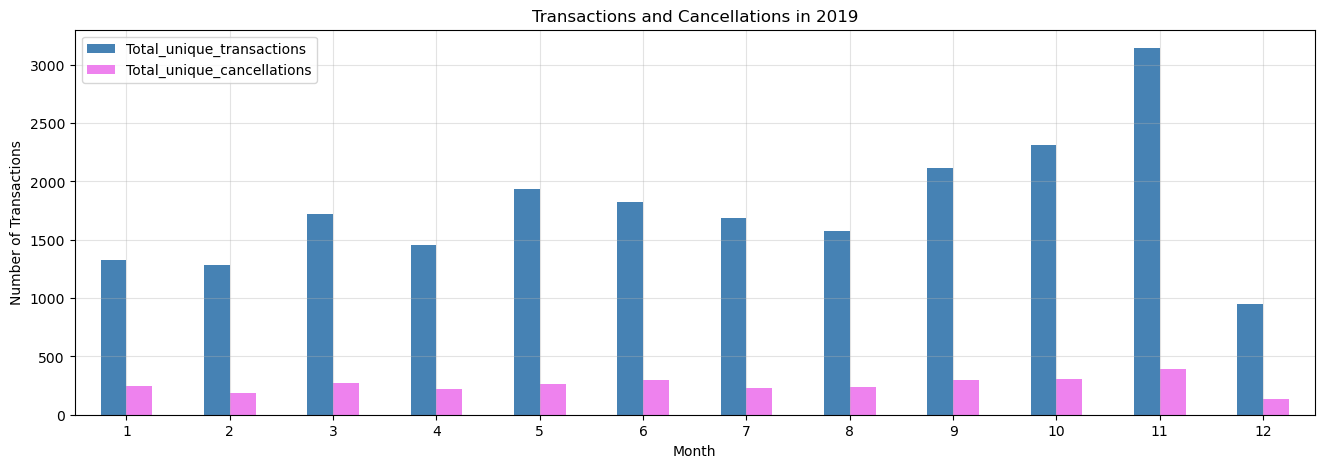

In [107]:
# Calculate the number of unique transactions per month 
monthly_transactions = df.groupby(by=["Month"]).agg({"Transaction_id":"nunique"})
monthly_transactions.rename(columns={"Transaction_id":"Total_unique_transactions"}, inplace=True)

# Calculate the number of unique cancellations per month 
monthly_cancellations = cancelled.groupby(by=["Month"]).agg({"Transaction_id":"nunique"}).rename({"Tansaction_id":"Unique_cancellations"})
monthly_cancellations.rename(columns={"Transaction_id":"Total_unique_cancellations"}, inplace=True)

# Create a new dataframe that contains total unique transactions, as well as the number of cancellations
total_monthy_transactions = pd.merge(monthly_transactions,monthly_cancellations, how="inner", on="Month")

# Ploting the results
total_monthy_transactions.plot.bar(figsize=[16,5], rot=0, title="Transactions and Cancellations in 2019", color=["steelblue","violet"])
plt.ylabel("Number of Transactions")
plt.grid(alpha=0.35)
plt.show()


#### Filtering out cancelled transactions, we will focus only on valid purchases forward

In [108]:
df = df.drop(df[df["Quantity"]<0].index)

#### Distribution of completed transactions per month of 2019

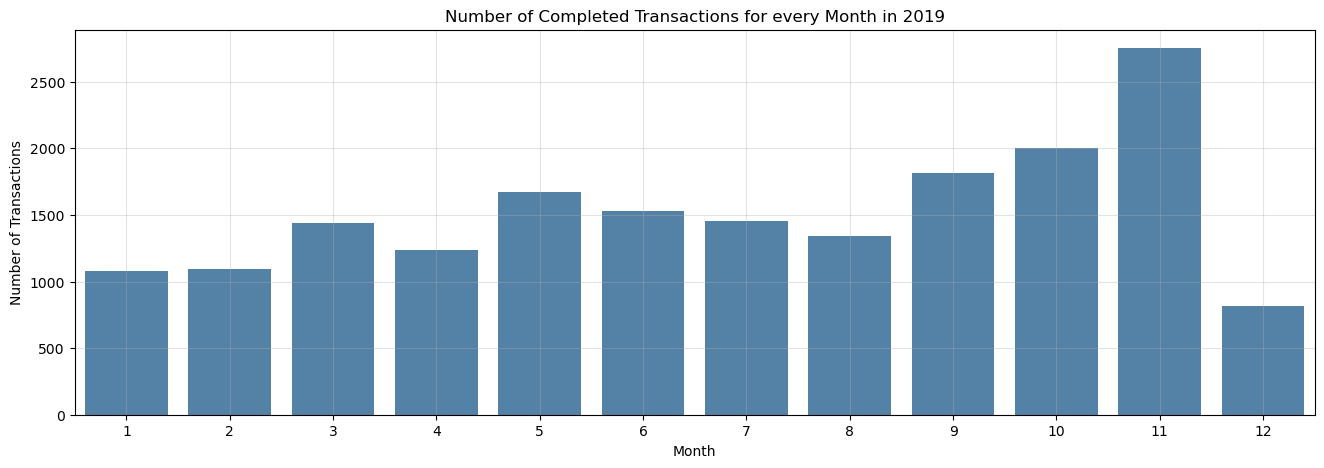

In [109]:
# How are transactions distributed in each month.
montlhy_valid_transactions = df.groupby(by = ["Month"]).agg({"Transaction_id": "nunique"})

# Plot the bar graph 
plt.figure(figsize=[16,5])
sns.barplot(data=montlhy_valid_transactions, x=montlhy_valid_transactions.index, y="Transaction_id", color="steelblue")

# Add title and labels
plt.title("Number of Completed Transactions for every Month in 2019")
plt.ylabel("Number of Transactions")
plt.xlabel("Month")
plt.grid(alpha=0.35)
plt.show()

#### Transactions per day of each month for 2019

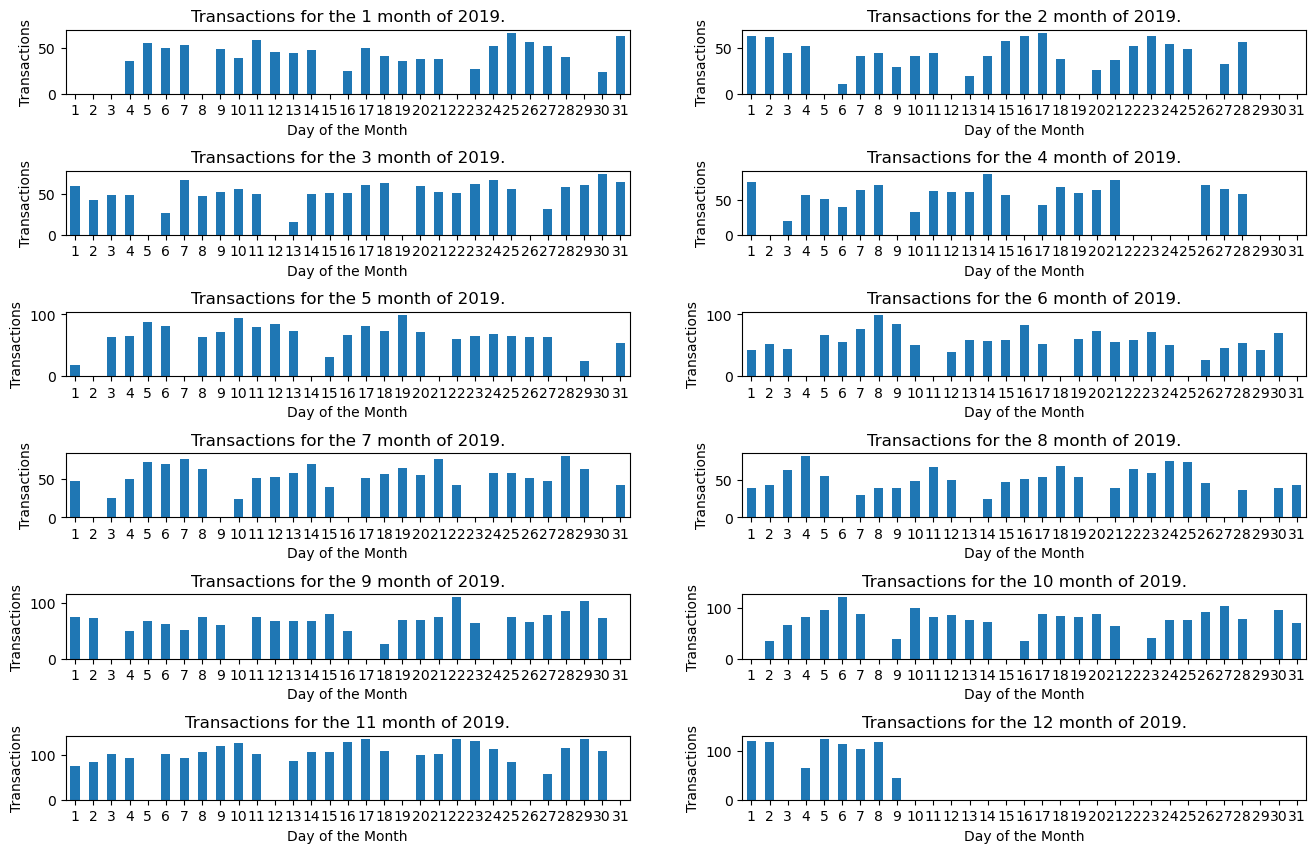

In [110]:
daily_transactions = df.groupby(by = ["Month","Day"]).agg({"Transaction_id": "nunique"})

# Plotting the transactions for every month of 2019
fig, axs = plt.subplots(nrows=6, ncols=2, figsize=[16,10])
axs = axs.ravel()
for i, row in daily_transactions.unstack().iterrows():
    row.plot.bar(ax = axs[i-1], title = f"Transactions for the {i} month of 2019.", rot=0)
    axs[i-1].set_xticklabels(range(1,32))
    axs[i-1].set_xlabel("Day of the Month")
    axs[i-1].set_ylabel("Transactions")
plt.subplots_adjust(hspace=1.2)
plt.show()


#### Transactions per day of the week for 2019

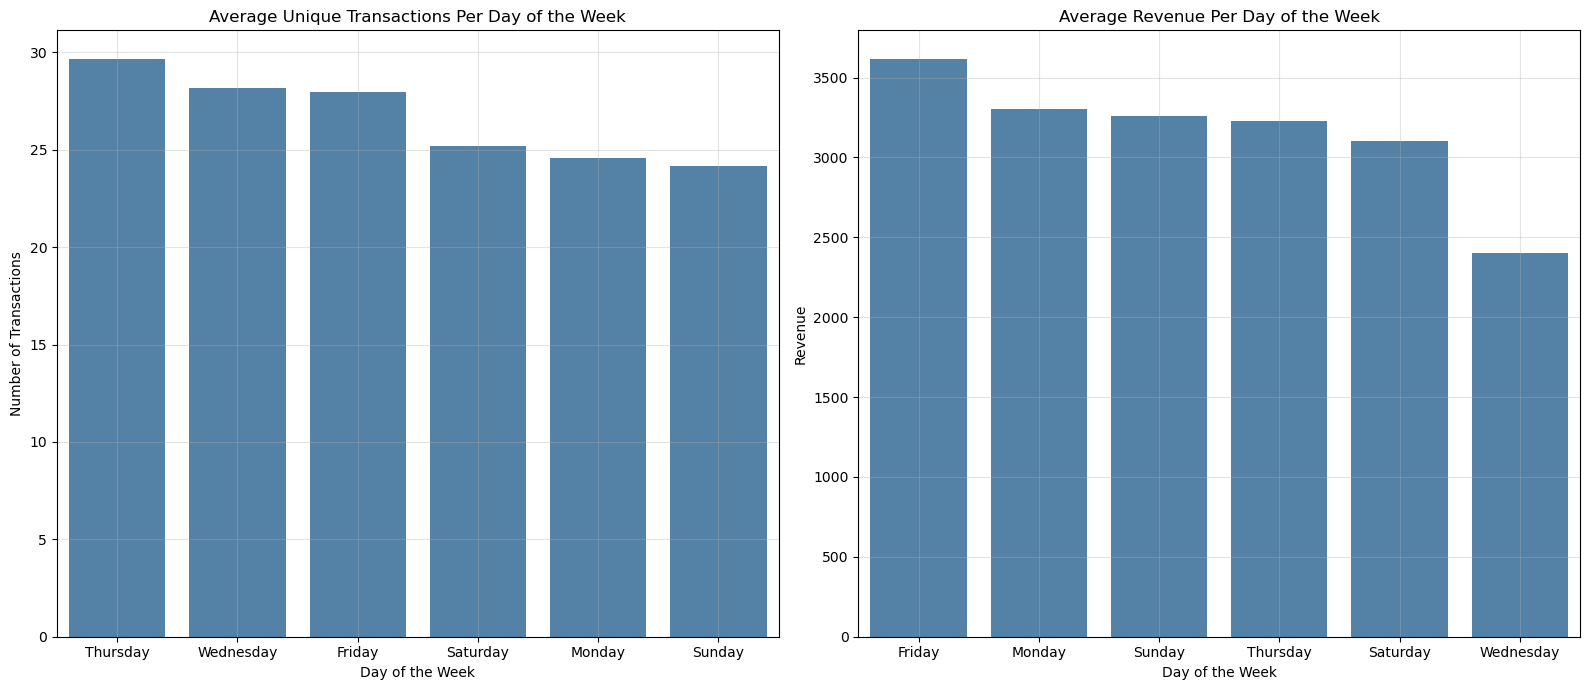

In [111]:
# Calculate mean number of transactions per day of the week
unique_daily_transactions = df.groupby(by=["Day_name","Transaction_id"])["Transaction_id"].count().reset_index(name="Transaction_count")
mean_daily_transactions = unique_daily_transactions.groupby(by=["Day_name"])["Transaction_count"].mean().sort_values(ascending=False)

# Calculate mean revenue per day of the week
total_daily_revenue = df.groupby(by=["Day_name","Transaction_id"])["Transaction_profit"].sum().reset_index(name="Revenue")
mean_daily_revenue = total_daily_revenue.groupby(by=["Day_name"])["Revenue"].mean().sort_values(ascending=False)

# Plot the bar graph
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16,7])

ax1 = sns.barplot(x=mean_daily_transactions.index, y=mean_daily_transactions.values, color="steelblue", ax=ax1)
ax1.set_title("Average Unique Transactions Per Day of the Week")
ax1.set_xlabel("Day of the Week")
ax1.set_ylabel("Number of Transactions")
ax1.grid(alpha=0.35)

ax2 = sns.barplot(x=mean_daily_revenue.index, y=mean_daily_revenue.values, color="steelblue", ax=ax2)
ax2.set_title("Average Revenue Per Day of the Week")
ax2.set_xlabel("Day of the Week")
ax2.set_ylabel("Revenue")
ax2.grid(alpha=0.35)

plt.tight_layout()
plt.show()

It should be highlighted that there are no transaction data for Tuesdays.

#### 10 dates with the most/least transactions in 2019

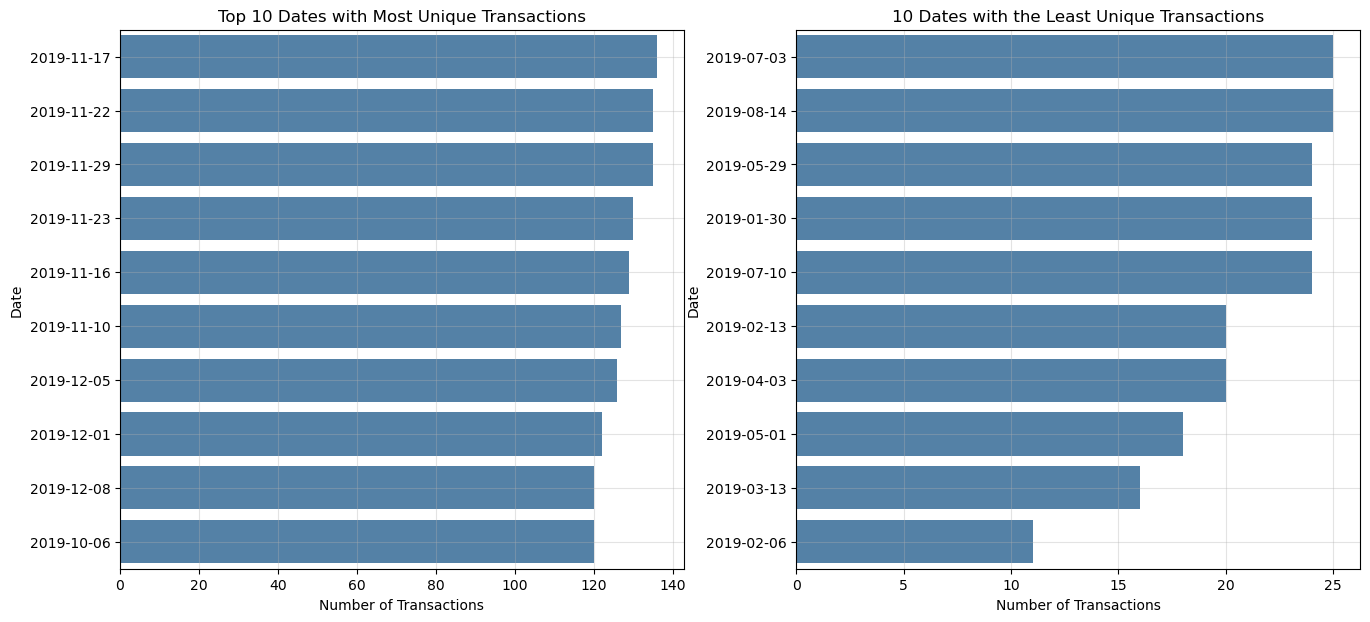

In [112]:
daily_transactions = df.groupby(by = ["Date"])["Transaction_id"].nunique()
daily_transactions.sort_values(ascending=False, inplace=True)
top_ten = daily_transactions[:10]
bottom_ten = daily_transactions[len(daily_transactions)-10:]

# Plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16,7])

ax1 = sns.barplot(x=top_ten.values, y=top_ten.index.date, orient="h", color="steelblue", ax=ax1)
ax1.set_title("Top 10 Dates with Most Unique Transactions")
ax1.set_xlabel("Number of Transactions")
ax1.set_ylabel("Date")
ax1.grid(alpha=0.35)

ax2 = sns.barplot(x=bottom_ten.values, y=bottom_ten.index.date, orient="h", color="steelblue", ax=ax2)
ax2.set_title("10 Dates with the Least Unique Transactions")
ax2.set_xlabel("Number of Transactions")
ax2.set_ylabel("Date")
ax2.grid(alpha=0.35)

plt.show()

#### Number of unique products in the dataframe

In [113]:
unique_products =  df["Product_id"].nunique()
print(f"There are {unique_products} unique products in the dataframe.")

There are 3676 unique products in the dataframe.


#### Product prices boxplot

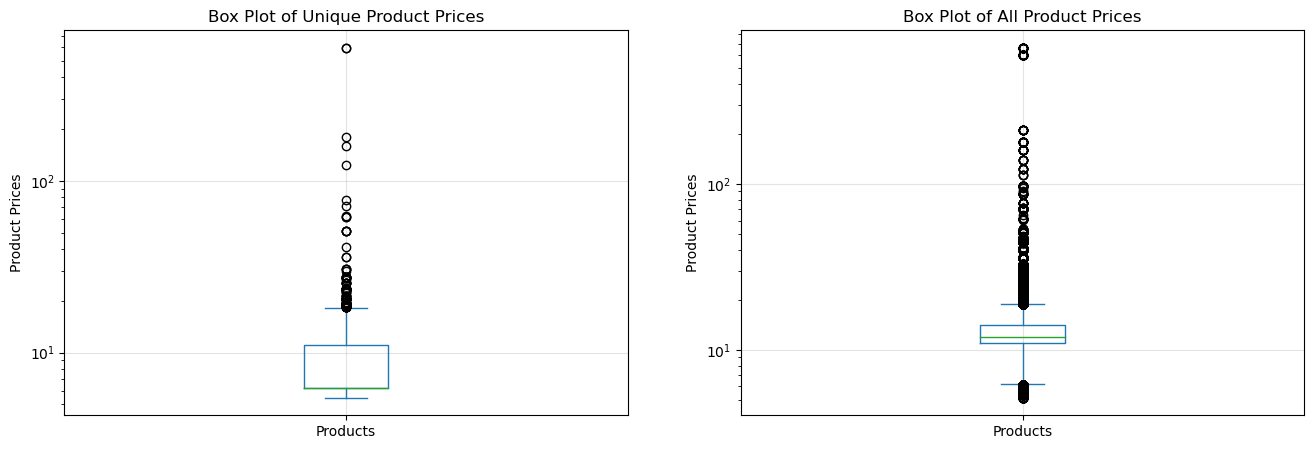

In [114]:
unique_products = df.drop_duplicates(subset=["Product_id"])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16,5])

unique_products["Price"].plot.box(ax=ax1)
ax1.set_title("Box Plot of Unique Product Prices")
ax1.set_ylabel("Product Prices")
ax1.set_yscale("log")
ax1.set_xticklabels(["Products"])
ax1.grid(alpha=0.35)

df["Price"].plot.box(ax=ax2)
ax2.set_title("Box Plot of All Product Prices")
ax2.set_ylabel("Product Prices")
ax2.set_yscale("log")
ax2.set_xticklabels(["Products"])
ax2.grid(alpha=0.35)

plt.show()

It is apparent that the products in the dataset have been sold throughout the year in different prices.

#### Distribution of price values among the products

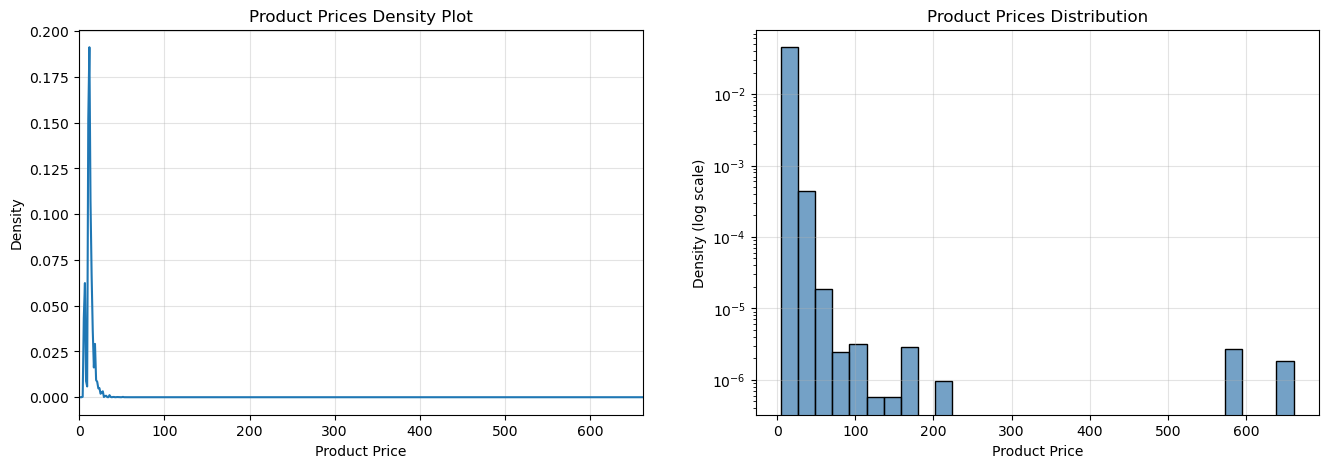

In [115]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16,5])

ax1 = df["Price"].plot.density(ax=ax1)
ax1.set_xlim(0,df["Price"].max()+1)
ax1.set_title("Product Prices Density Plot")
ax1.set_xlabel("Product Price")
ax1.grid(alpha=0.35)

ax2 = sns.histplot(df["Price"], bins=30, color="steelblue", stat="density", ax=ax2)
ax2.set_title("Product Prices Distribution")
ax2.set_xlabel("Product Price")
ax2.set_yscale("log")
ax2.set_ylabel("Density (log scale)")
ax2.grid(alpha=0.35)

plt.show()

In [116]:
same_product_prices = df.groupby(by=["Product_id"])["Price"].nunique()
same_product_prices = same_product_prices.sort_values(ascending = False)
same_product_prices = same_product_prices[same_product_prices.values>1]

print(f'Out of all the unique products in the dataset, {len(same_product_prices)} products appear to have been sold at more than one different prices.')
print(f'The product with id: {same_product_prices.index[0]} appears to has the highest variety of prices with {same_product_prices[0]} different prices.')

Out of all the unique products in the dataset, 3328 products appear to have been sold at more than one different prices.
The product with id: 79321 appears to has the highest variety of prices with 22 different prices.


#### Analyzing the price ranges for products with more than one recorded price

In [117]:
# Group the data by 'Product_id' and calculate the range of the 'Price' column for each group
price_ranges = df.groupby(by=["Product_id"]).agg({"Price":lambda x: x.max()-x.min()}).rename(columns={"Price":"Price_range"})

# Filter the dataframe to keep only products with more than one price
price_ranges = price_ranges[price_ranges["Price_range"] != 0]
price_ranges.sort_values(by = ["Price_range"], ascending=False, inplace=True)
print("List of top 5 products with the widest range of prices \n")
print(price_ranges.head())
print("\n List of top 5 products with the smallest range of prices \n")
print(price_ranges.tail())

List of top 5 products with the widest range of prices 

            Price_range
Product_id             
22826            203.93
23064             92.21
84078A            82.52
21473             82.01
21686             75.13

 List of top 5 products with the smallest range of prices 

            Price_range
Product_id             
20774              0.02
85086A             0.02
90123C             0.01
90001D             0.01
21801              0.01


Even though the price ranges are largely in the range of under a sterling, there are some notable outliers with products that appear to have been sold with a price gap of around 200 sterlings.

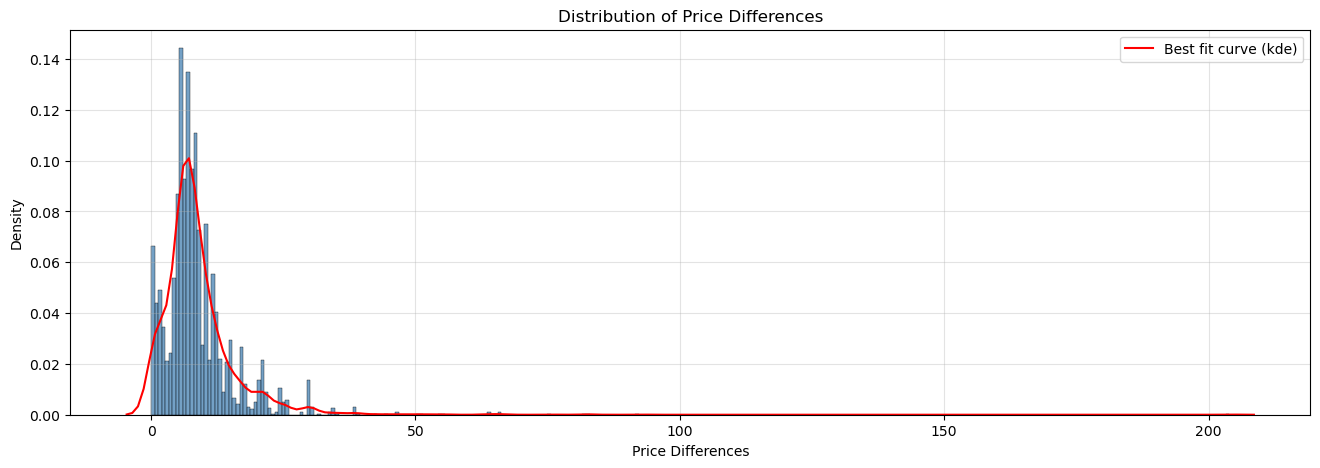

In [118]:
# Plotting the distribution of the recorded price ranges among same products
plt.figure(figsize=(16,5))
sns.histplot(price_ranges["Price_range"], color="steelblue", stat="density")
sns.kdeplot(price_ranges["Price_range"], color="red", label="Best fit curve (kde)")
plt.title("Distribution of Price Differences")
plt.xlabel("Price Differences")
plt.grid(alpha=0.35)
plt.legend()
plt.show()

#### Examining the customer demographics

In [119]:
# Calculating number of customers per unique country in dataframe
demographics =  df.groupby(by=["Country"])["Customer_id"].nunique()
demographics.sort_values(inplace=True)

# Calculating region specific demographics
total_non_uk = demographics[demographics.index != "United Kingdom"].values.sum()
total_uk = demographics[demographics.index == "United Kingdom"].values

total_global = total_non_uk + total_uk

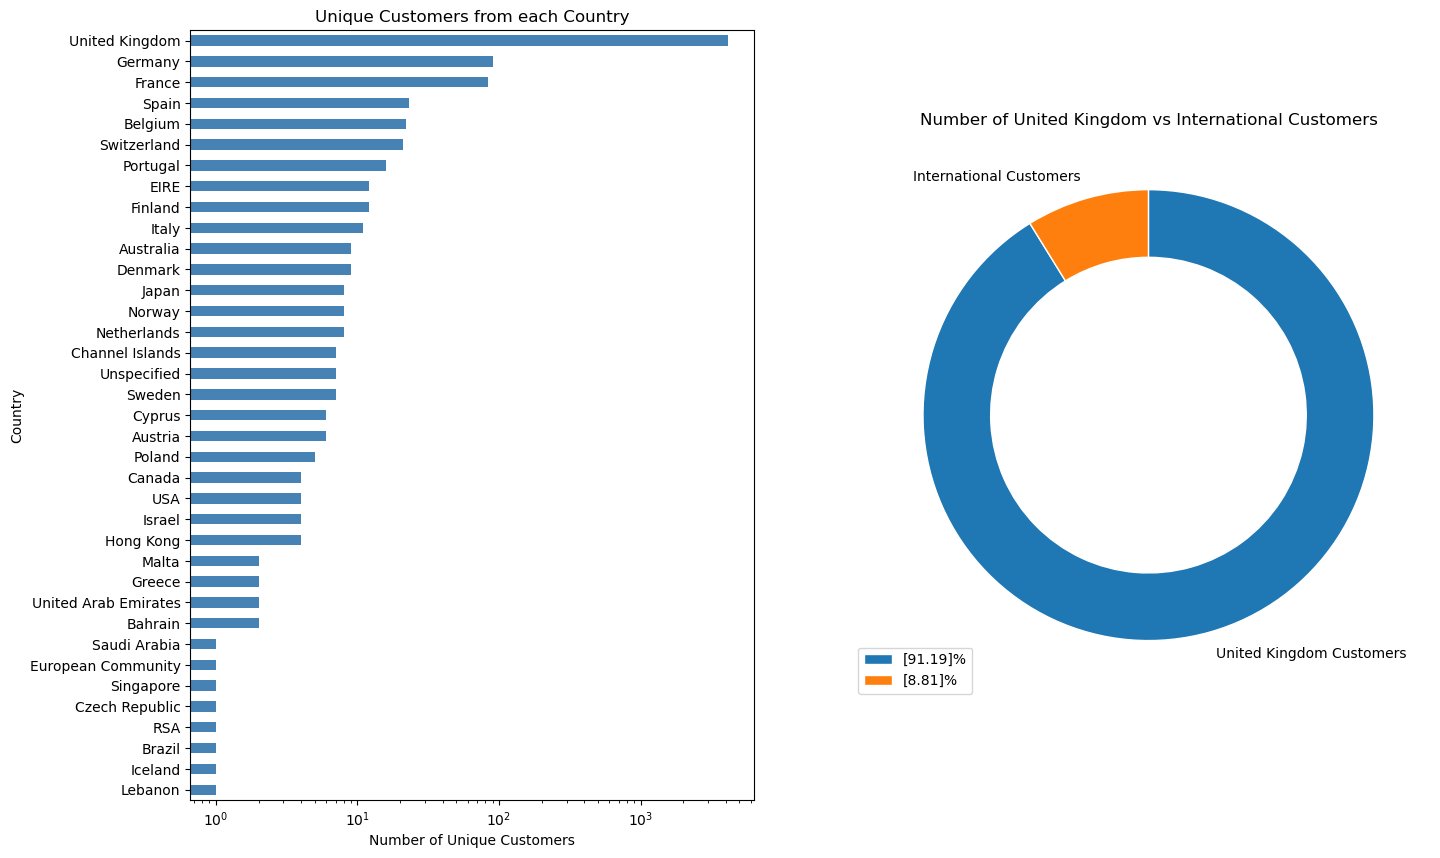

In [120]:
# Plotting the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16,10])

# Horizontal bar plot
ax1 = demographics.plot.barh(color="steelblue", ax=ax1)
ax1.set_xscale("log")
ax1.set_xlabel("Number of Unique Customers")
ax1.set_title("Unique Customers from each Country")

# Draw the pie chart
ax2 = plt.pie([total_uk,total_non_uk],labels=["United Kingdom Customers", "International Customers"],
startangle=90, counterclock=False, wedgeprops=dict(width=0.3, edgecolor="w"))
plt.title("Number of United Kingdom vs International Customers")

# Add a legend with percentages on the pie chart
plt.legend([f"{np.round(total_uk/total_global *100,2)}%", f"{np.round(total_non_uk/total_global * 100,2)}%"],
bbox_to_anchor=(0.2, 0.1))

plt.show() 

In [121]:
# Add a new feature column to identify domestic from international customers
df["Domestic"] =  df["Country"].apply(lambda x: x=="United Kingdom")

#### Monthly revenue for 2019 from Domestic and International Transactions

In [122]:
# Calculate monthly revenue
monthly_revenue = df.groupby(by=["Month","Domestic"]).agg({"Transaction_profit":np.sum})

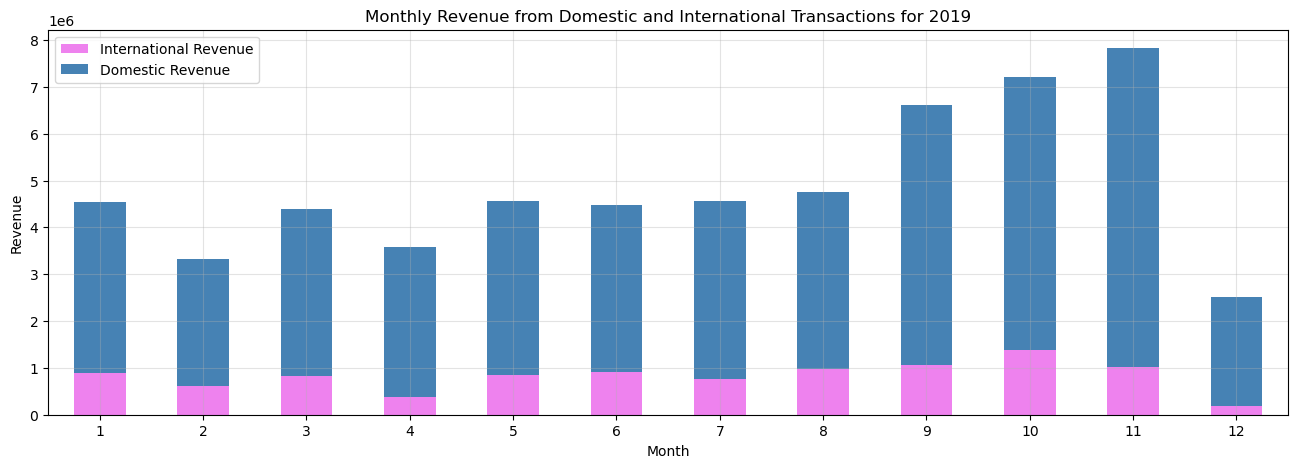

In [123]:
# Plotting Monthly Revenue from both Domestic and International Customers
monthly_revenue.unstack().plot.bar(stacked=True, rot=0,figsize=[16,5], color=["violet","steelblue"])
plt.title("Monthly Revenue from Domestic and International Transactions for 2019")
plt.ylabel("Revenue")
plt.legend(["International Revenue", "Domestic Revenue"])
plt.grid(alpha=0.35)
plt.show()

#### Relation between number of unique transactions and revenue produced in a monthly basis

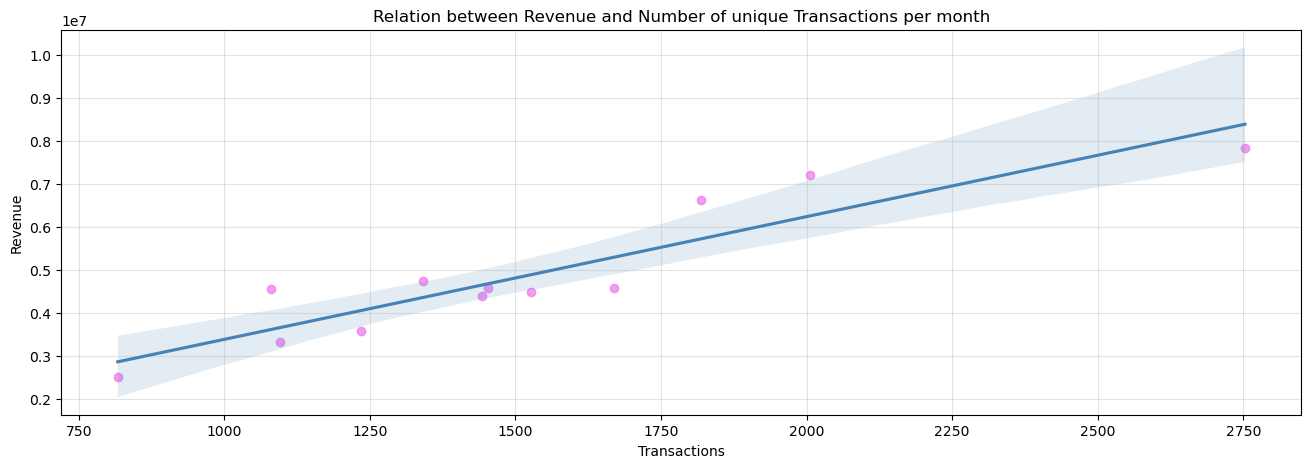

In [124]:
# Calculate the monthly revenue vs number of transactions for a scatter plot
revenue_transactions =  df.groupby(by=["Month"]).agg(Unique_transactions=("Transaction_id","nunique"), Revenue=("Transaction_profit","sum"))

# Plot the results and add a regression line

plt.figure(figsize=[16,5])
ax = sns.regplot(data=revenue_transactions, x="Unique_transactions", y="Revenue", color="steelblue", scatter_kws={"color":"violet"})
ax.set_title("Relation between Revenue and Number of unique Transactions per month")
ax.set_xlabel("Transactions")
ax.set_ylabel("Revenue")
ax.grid(alpha=0.35)
plt.show()

#### Daily revenue for 2019 from Domestic and International Transactions

In [125]:
# Calculate daily revenue, domestic and international
daily_revenue = df.groupby(by=["Date","Domestic"]).agg({"Transaction_profit":np.sum})

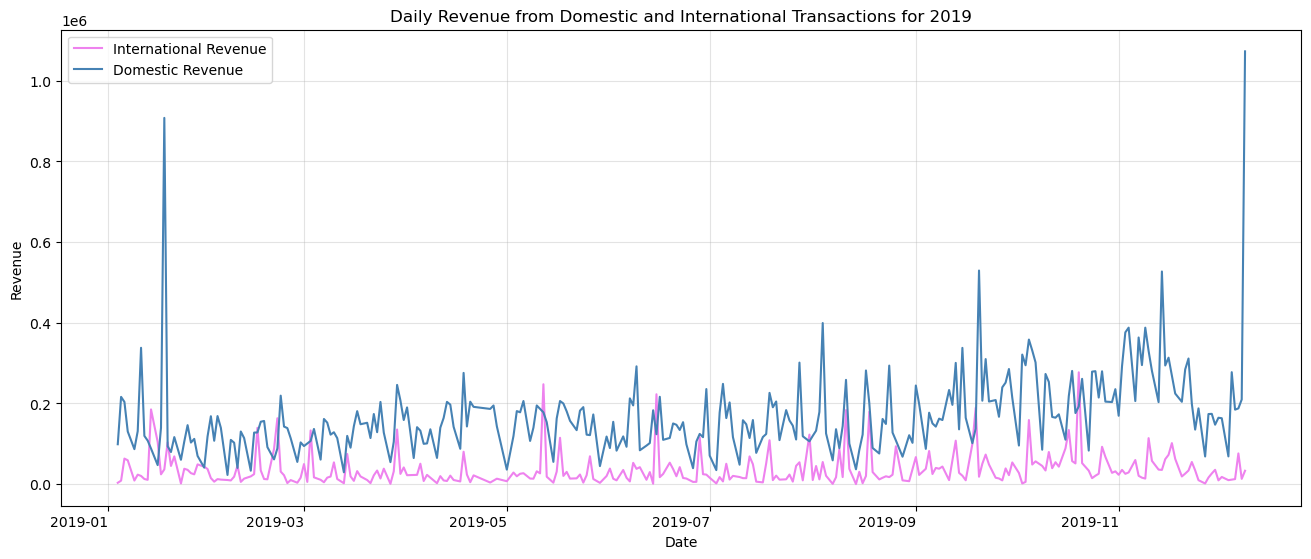

In [126]:
# Plot the daily revenue from Domestic and International transactions - used built in interpolation for missing dates
daily_revenue.unstack().interpolate().plot.line(rot=0,figsize=[16,7], color=["violet","steelblue"])
plt.title("Daily Revenue from Domestic and International Transactions for 2019")
plt.ylabel("Revenue")
plt.legend(["International Revenue", "Domestic Revenue"])
plt.grid(alpha=0.35)
plt.show()

In [127]:
# Add a regression line for the timeseries of total daily transactions 
global_daily_revenue = df.groupby(by=["Date"]).agg({"Transaction_profit":np.sum}).rename(columns={"Transaction_profit":"Revenue"})

# Calculate a numerical value for the dates (independent variable)
global_daily_revenue["Date_num"] = (global_daily_revenue.index - pd.Timestamp("1970-01-01")) // pd.Timedelta("1d")

# Initialise an instance of the LinearRegression model
model = LinearRegression()

# Independent variable
X = global_daily_revenue["Date_num"].values.reshape(-1,1)

# Dependent variable
Y = global_daily_revenue["Revenue"]

# Fit the model to the data - we will be using all of the data to produce a regression fit for this time period
model.fit(X, Y)

# Calculate the predicted Revenue values into a new column
global_daily_revenue["Revenue_pred"]= model.predict(X)

#Calculate regression parameters

intercept = model.intercept_
slope = model.coef_[0]
r_squared =  model.score(X,Y)
std_err = np.sqrt((1 - r_squared) * np.var(Y, ddof=1) / global_daily_revenue.shape[0])

# Calculate the t-value for a 95% confidence level
t = stats.t.ppf(0.975, global_daily_revenue.shape[0]-2)

# Calculate the margin of error
me = std_err * t

# Calculate error margin lines for linear regression 
lower = (intercept + slope * global_daily_revenue["Date_num"]) - me
upper = (intercept + slope * global_daily_revenue["Date_num"]) + me

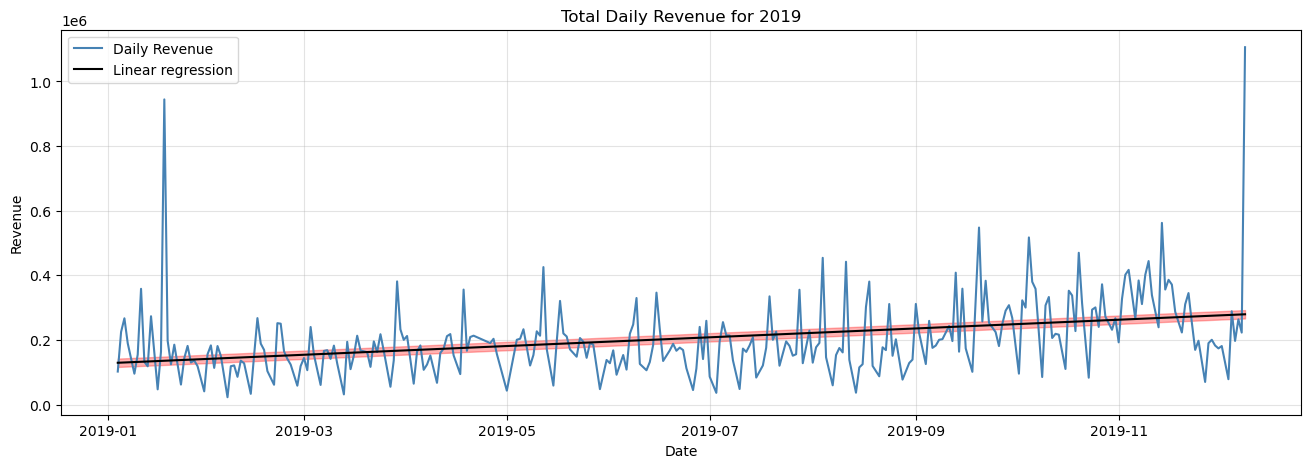

In [128]:
# Plotting the linear regression of revenue from global transactions
plt.figure(figsize=[16,5])
sns.lineplot(data=global_daily_revenue, x=global_daily_revenue.index, y="Revenue", color="steelblue")
sns.lineplot( data=global_daily_revenue, x=global_daily_revenue.index, y="Revenue_pred", color="black")
plt.fill_between(global_daily_revenue["Date_num"], lower, upper, color="red", alpha=0.3)
plt.title("Total Daily Revenue for 2019")
plt.ylabel("Revenue")
plt.legend(["Daily Revenue", "Linear regression"])
plt.grid(alpha=0.35)
plt.show()


#### Examining December 2019 large spike in revenue

In [129]:
# Create a December 2019 dataframe
december = df[df["Month"]==12]

# Number of unique transactions per day of December 2019
u_trans_decem = december.groupby(by=["Date"])["Transaction_id"].nunique()

# Revenue per day of December 2019
revenue_decem = december.groupby(by=["Date"])["Transaction_profit"].sum()

# Number of unique customers per day of December 2019
customers_decem = december.groupby(by=["Date","Domestic"])["Customer_id"].nunique()

# Product popularity of December 2019
products_decem = december.groupby(by=["Product_id"])["Product_id"].count()

# Average product prices sold during December 2019
product_prices = december.groupby(by=["Product_id"])["Price"].mean()

# Average product quantities sold during December 2019
product_quantities = december.groupby(by=["Product_id"])["Quantity"].mean()

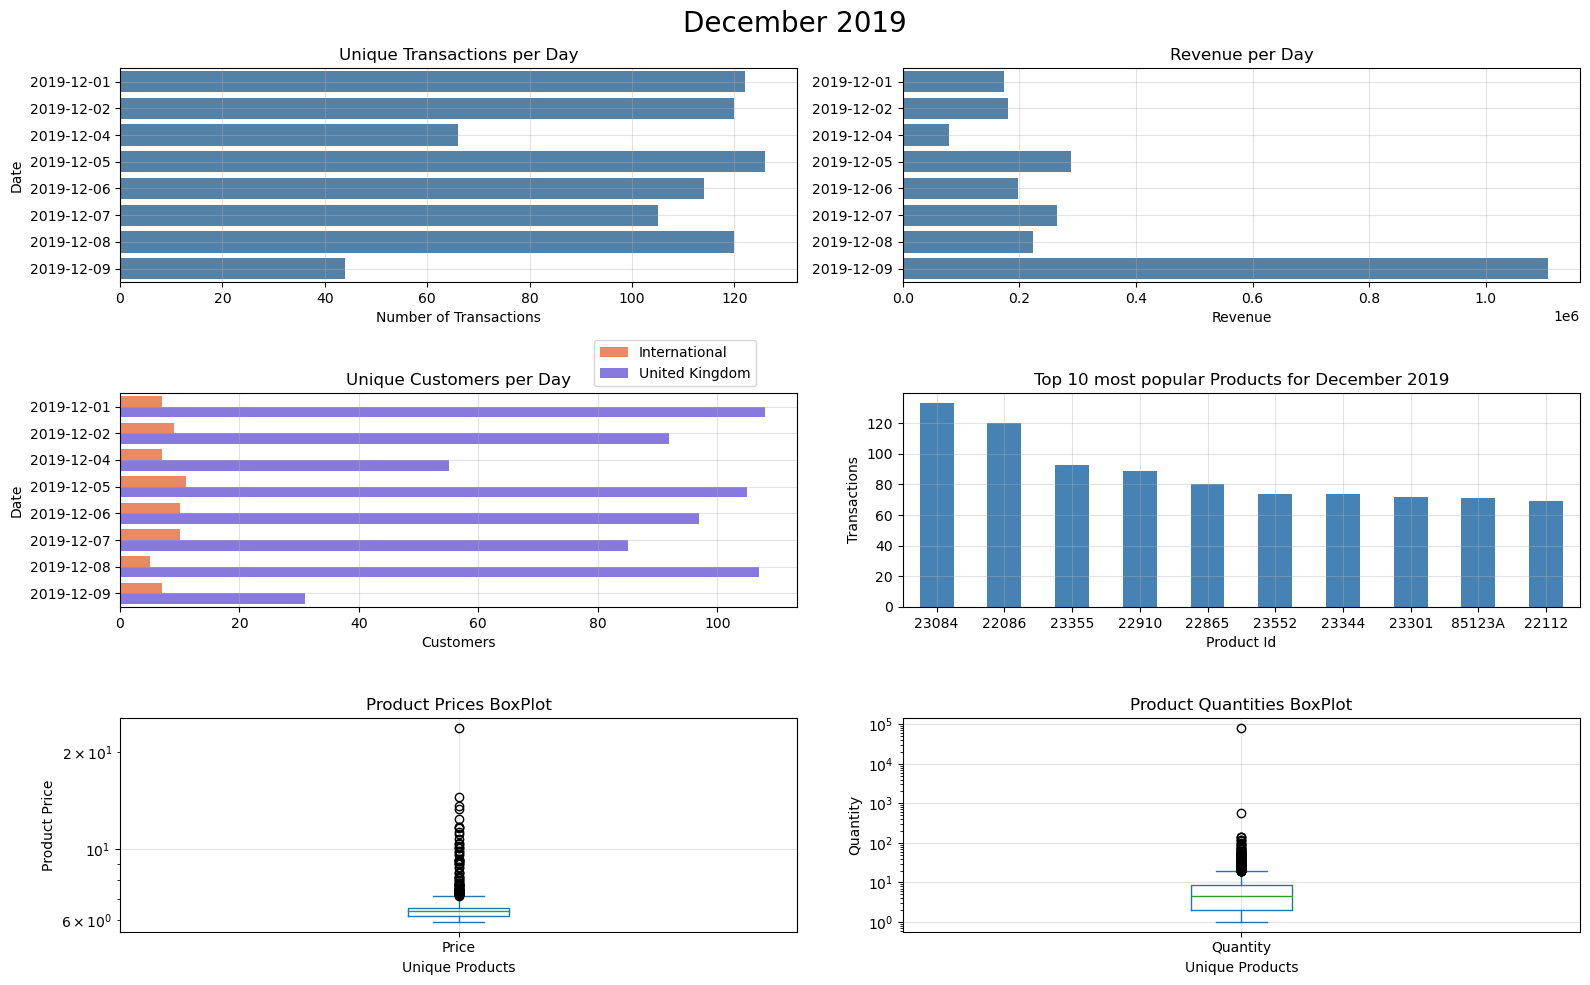

In [130]:
# Plotting the results
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2, figsize=[16,10])

ax1 = sns.barplot(y=u_trans_decem.index.date, x=u_trans_decem.values, color="steelblue", orient="h", ax=ax1)
ax1.set_title("Unique Transactions per Day")
ax1.set_ylabel("Date")
ax1.set_xlabel("Number of Transactions")
ax1.grid(alpha=0.35)

ax2 = sns.barplot(y=revenue_decem.index.date, x=revenue_decem.values, orient="h", color="steelblue", ax=ax2)
ax2.set_title("Revenue per Day")
ax2.set_xlabel("Revenue")
ax2.grid(alpha=0.35)

ax3 = sns.barplot(y=customers_decem.reset_index("Domestic").index.date, x=customers_decem.reset_index().Customer_id.values,
hue=customers_decem.reset_index().Domestic.values, orient="h", ci=None, palette=["coral","mediumslateblue"], ax=ax3)
ax3.set_title("Unique Customers per Day")
ax3.set_xlabel("Customers")
ax3.set_ylabel("Date")
ax3.legend(["International","United Kingdom"], bbox_to_anchor=[0.69,1])
ax3.grid(alpha=0.35)

ax4 = products_decem.sort_values(ascending=False)[:10].plot.bar(ax=ax4, color="steelblue", rot=0)
ax4.set_title("Top 10 most popular Products for December 2019")
ax4.set_xlabel("Product Id")
ax4.set_ylabel("Transactions")
ax4.grid(alpha=0.35)

ax5 = product_prices.plot.box(ax=ax5)
ax5.set_title("Product Prices BoxPlot")
ax5.set_xlabel("Unique Products")
ax5.set_ylabel("Product Price")
ax5.set_yscale("log")
ax5.grid(alpha=0.35)

ax6 = product_quantities.plot.box(ax=ax6)
ax6.set_title("Product Quantities BoxPlot")
ax6.set_xlabel("Unique Products")
ax6.set_ylabel("Quantity")
ax6.set_yscale("log")
ax6.grid(alpha=0.35)

plt.suptitle("December 2019", fontsize=20)
plt.tight_layout()
plt.show()

By examining the Revenue per Day bar plot, we identify a surge in profit on the 09-12-2019. After analysing both prices and quantities of products sold in December we can safely pinpoint to the outlier that produces this result in the retail dataset.

In [131]:
print(f"The product with ID: {product_quantities.idxmax()} appears to have sold {int(product_quantities.max())} units, on 09-12-2019")

The product with ID: 23843 appears to have sold 80995 units, on 09-12-2019


### Market Basket Analysis <a class="anchor" id="market-basket-analysis"></a>

In [132]:
# Create a new dataframe for the market basket analysis
mba =  df.groupby(by=["Transaction_id","Product_name"])["Quantity"].sum().unstack().reset_index().fillna(0).set_index("Transaction_id")

In [133]:
# Encode data (1 if there is at least one purchase of the product, 0 if none)
mba = mba.applymap(lambda x: 0 if (x<=0) else 1)

In [134]:
# Filtering transactions with more than one item
mba =  mba[(mba>0).sum(axis=1)>=2]

In [135]:
# Use the apriori algorith to find the frequently bought item sets bought in the data
freq_itemsets =  apriori(mba, min_support=0.03, use_colnames=True).sort_values("support",ascending=False).reset_index(drop=True)
freq_itemsets["length"] = freq_itemsets["itemsets"].apply(lambda x: len(x))

In [136]:
# Find the association rules
rules = association_rules(freq_itemsets, metric="lift", min_threshold=1).sort_values("lift", ascending=False).reset_index(drop=True)
rules


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Pink Regency Teacup And Saucer),"(Green Regency Teacup And Saucer, Roses Regenc...",0.044863,0.042614,0.031960,0.712401,16.717678,0.030048,3.328894
1,"(Green Regency Teacup And Saucer, Roses Regenc...",(Pink Regency Teacup And Saucer),0.042614,0.044863,0.031960,0.750000,16.717678,0.030048,3.820549
2,"(Roses Regency Teacup And Saucer, Pink Regency...",(Green Regency Teacup And Saucer),0.035334,0.056226,0.031960,0.904523,16.087173,0.029974,9.884787
3,(Green Regency Teacup And Saucer),"(Roses Regency Teacup And Saucer, Pink Regency...",0.056226,0.035334,0.031960,0.568421,16.087173,0.029974,2.235202
4,(Green Regency Teacup And Saucer),(Pink Regency Teacup And Saucer),0.056226,0.044863,0.037287,0.663158,14.781947,0.034764,2.835564
5,(Pink Regency Teacup And Saucer),(Green Regency Teacup And Saucer),0.044863,0.056226,0.037287,0.831135,14.781947,0.034764,5.588910
6,"(Green Regency Teacup And Saucer, Pink Regency...",(Roses Regency Teacup And Saucer),0.037287,0.059008,0.031960,0.857143,14.525863,0.029760,6.586944
7,(Roses Regency Teacup And Saucer),"(Green Regency Teacup And Saucer, Pink Regency...",0.059008,0.037287,0.031960,0.541625,14.525863,0.029760,2.100273
8,(Gardeners Kneeling Pad Cup Of Tea),(Gardeners Kneeling Pad Keep Calm),0.044804,0.053977,0.032315,0.721268,13.362442,0.029897,3.394025
9,(Gardeners Kneeling Pad Keep Calm),(Gardeners Kneeling Pad Cup Of Tea),0.053977,0.044804,0.032315,0.598684,13.362442,0.029897,2.380162


The above dataframe contains the results of association rule mining using market basket analysis. Let's describe the meaning of the columns of this dataset:

- **antecedents**: The set of items that appear in the antecedent of the association rule.

- **consequents**: The set of items that appear in the consequent of the association rule.

- **antecedent support**: The proportion of transactions in the dataset that contain the antecedent.

- **consequent support**: The proportion of transactions in the dataset that contain the consequent.

- **support**: The proportion of transactions that contain both the antecedent and the consequent. It represents the frequency with which the rule occurs in the data set.

- **confidence**: The proportion of transactions that contain the antecedent that also contain the consequent. It measures the strength of the rule.

- **lift**: The ratio of observed support to expected support if the antecedent and consequent were independent.

- **leverage**: The difference between observed support and expected support if the antecedent and consequent were independent.

- **conviction**: The ratio of the expected frequency that the antecedent appears without the consequent to the observed frequency of the antecedent appearing without the consequent.

These metrics provide information about the strength and relevance of the association rules that were discovered through market basket analysis. For example, _high confidence and lift values indicate strong associations between antecedents and consequents_, while _high leverage values suggest that the association is unlikely to be due to chance_.




### Customer retention through Cohort Analysis <a class="anchor" id="customer-retention-through-cohort-analysis"></a>

In [137]:
# Finding the percentage of customers that came back after completing a purchase
transactions_per_customer = df.groupby(by=["Customer_id"]).agg({"Transaction_id":"nunique"})
mult_orders_perc = np.sum(transactions_per_customer > 1) / df["Customer_id"].nunique()
print(f"Percentage of customers that ordered more than once: {mult_orders_perc[0]*100:.2f}%")

Percentage of customers that ordered more than once: 65.24%


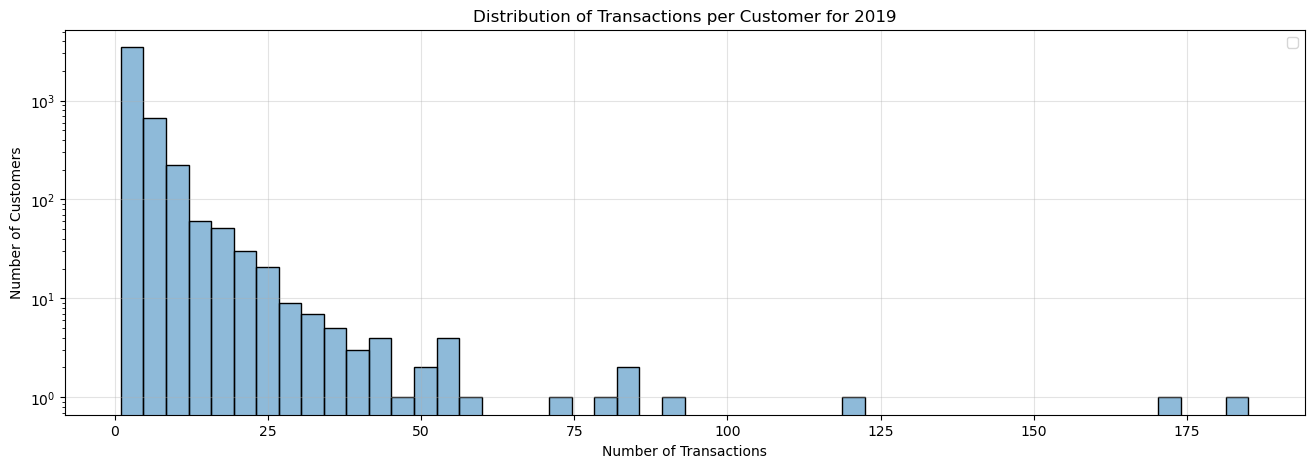

In [138]:
# Distribution of number of transactions per customer
plt.figure(figsize=[16,5])
ax = sns.histplot(transactions_per_customer, bins=50, color="steelblue")
ax.set_title("Distribution of Transactions per Customer for 2019")
ax.set_ylabel("Number of Customers")
ax.set_xlabel("Number of Transactions")
ax.set_yscale("log")
ax.legend([])
ax.grid(alpha=0.35)
plt.show()

In [139]:
# Creating a new dataframe that will have each transaction only once
cohort_df = df[["Customer_id","Transaction_id","Date"]].drop_duplicates(subset=["Transaction_id"]).reset_index(drop=True)

In [140]:
# Creating a new column for the cohorts of each customer (Monthly cohort based on the date of the first purchase)
cohort_df["Transaction_month"] = cohort_df["Date"].dt.to_period("M")
cohort_df["Cohort"] = cohort_df.groupby(by=["Customer_id"])["Date"].transform("min").dt.to_period("M")

In [141]:
# Calculate number of customers per cohort
cohorts = cohort_df.groupby(by=["Cohort", "Transaction_month"]).agg(Number_of_customers=("Customer_id", "nunique")).reset_index(drop=False)

# Calculate the number of periods between the cohort month and the month of the transaction
cohorts["Period_number"] =  (cohorts["Transaction_month"] - cohorts["Cohort"]).apply(attrgetter("n"))

In [142]:
# Create a pivot so that each row contains information about a given cohort and each column contains values for a certain period.
cohort_pivot = cohorts.pivot_table(index="Cohort", columns="Period_number", values="Number_of_customers")

In [143]:
# Creating the retention matrix
retention_matrix = cohort_pivot.divide(cohort_pivot.iloc[:,0], axis=0)

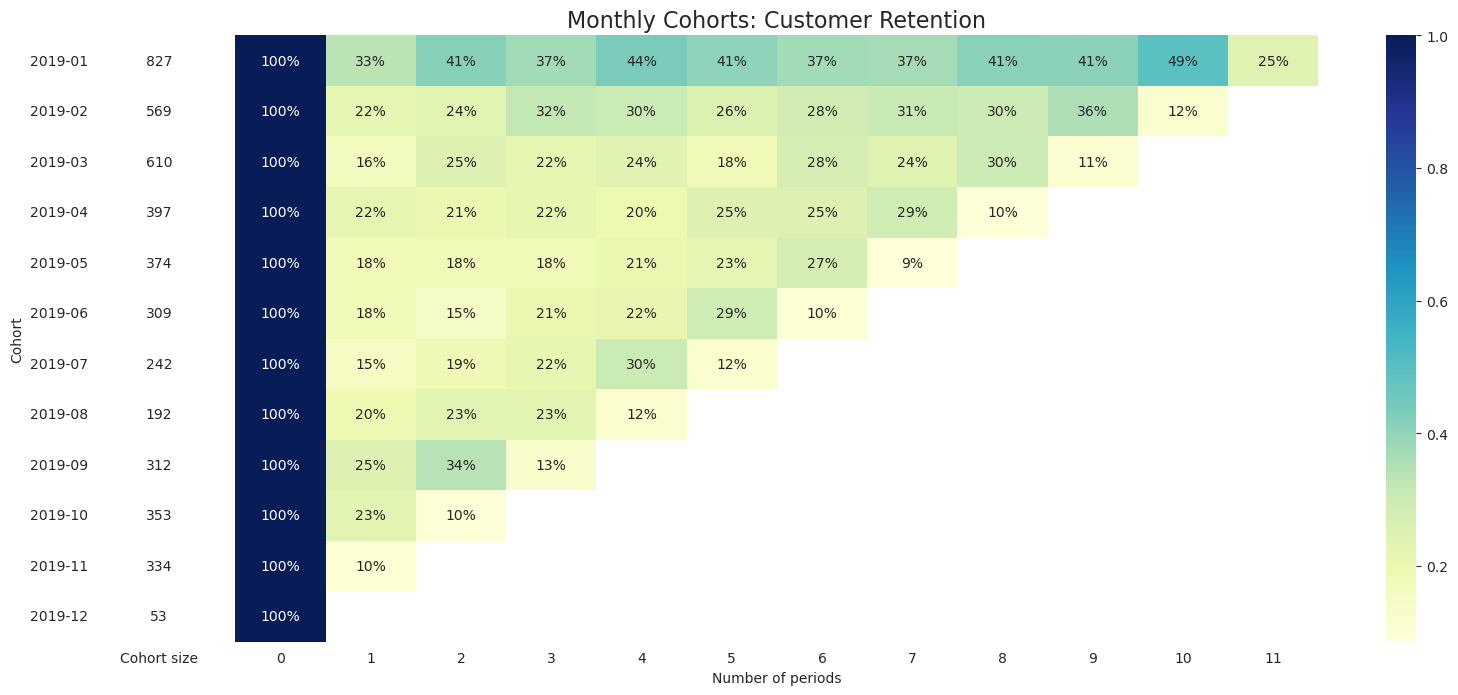

In [144]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=[16,7], sharey=True, gridspec_kw={"width_ratios": [1, 11]})
    
    # Plotting the retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt=".0%", 
                cmap="YlGnBu", 
                ax=ax[1])
    ax[1].set_title("Monthly Cohorts: Customer Retention", fontsize=16)
    ax[1].set_xlabel("Number of periods"),
    ax[1].set_ylabel("")

    # Plotting the cohort size 
    cohort_size_df = pd.DataFrame(cohort_pivot.iloc[:,0]).rename(columns={0: "Cohort size"})
    white_cmap = mcolors.ListedColormap(["White"])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt="g", 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

The above heatmap for the previously calculated retention matrix is a visual representation of the retention rates of customers within different cohorts over time. Each row in the heatmap represents a cohort of customers, grouped by the month they made their first purchase, while each column represents a subsequent period of time.

By analyzing a retention matrix heatmap, we can gain several insights about customers in our dataset, such as:

1. **Cohort behavior**: The heatmap allows us to compare the retention rates of different cohorts over time and determine if certain groups of customers exhibit different retention patterns. We can additionaly, identify which cohorts have high or low retention rates, and which cohorts show signs of decline or improvement over time.

2. **Retention trends**: By looking at the columns of the heatmap, it is easy to determine the retention rate changes over time. Trends, such as a decline in retention rates after a certain period of time or an improvement in retention rates after a specific event or action, become easily distinguisable.

3. **Customer lifetime value**: The heatmap can help in estimating the lifetime value of a customer. By identifying the length of time that customers are retained, it is possible to determine how much revenue each cohort will generate over time.

4. **Seasonality effects**: Seasonal or cyclical patterns in customer retention rates can also be infered throuht this heatmap. By identifying time periods when retention rates are higher, or that certain cohorts exhibit different retention patterns during specific seasons, we can come to valuable conclusions regarding sales seasonality.